In [ ]:
import kagglehub
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import time
import os
import shutil
from sklearn.metrics import classification_report
import cv2
import numpy as np

# Step 1: Download dataset
dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10")

# Step 2: Organize the dataset
original_dir = os.path.join(dataset_path, "raw-img")

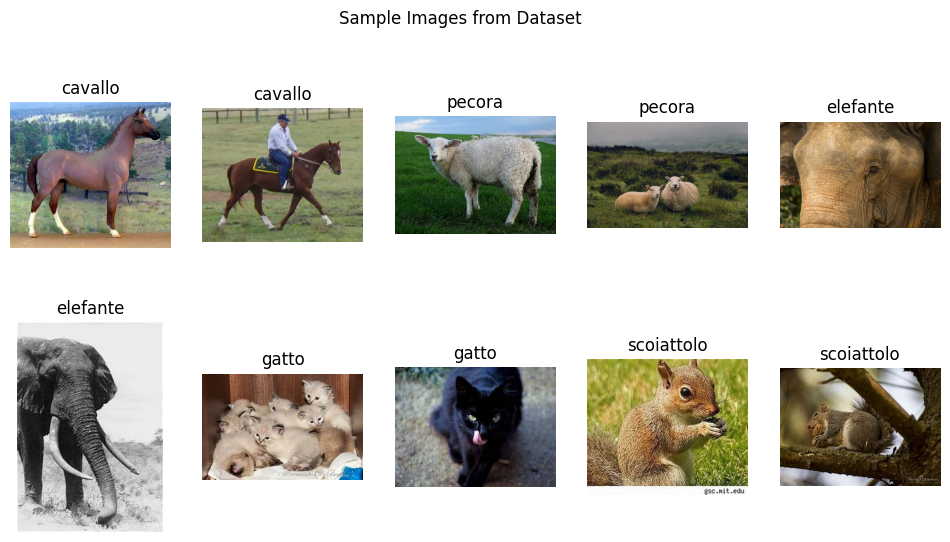

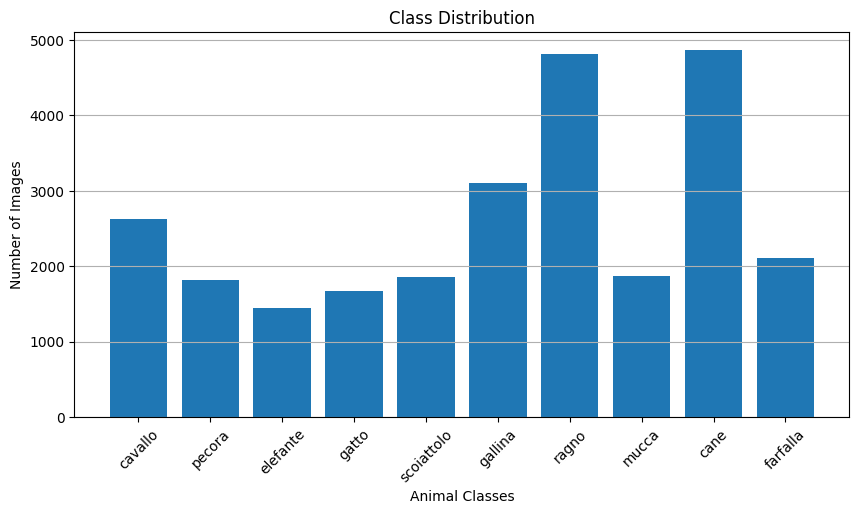


Checking for corrupt or blank images...
Found 0 corrupt or unreadable images.

Checking image shapes...
Unique image shapes: {(155, 200, 3), (300, 243, 3), (300, 254, 3), (215, 300, 3), (179, 185, 3), (206, 240, 3), (480, 640, 3), (187, 300, 3), (240, 194, 3), (195, 270, 3), (640, 627, 3), (640, 387, 3), (284, 300, 3), (429, 640, 3), (136, 300, 3), (224, 188, 3), (300, 205, 3), (300, 216, 3), (182, 182, 3), (120, 160, 3), (597, 640, 3), (465, 640, 3), (150, 200, 3), (267, 204, 3), (246, 287, 3), (240, 156, 3), (134, 300, 3), (313, 640, 3), (640, 578, 3), (437, 640, 3), (300, 273, 3), (300, 284, 3), (640, 483, 3), (236, 236, 3), (300, 167, 3), (300, 178, 3), (225, 277, 3), (349, 640, 3), (213, 180, 3), (267, 300, 3), (135, 300, 3), (157, 236, 3), (119, 300, 3), (412, 640, 3), (300, 235, 3), (255, 300, 3), (276, 300, 3), (300, 246, 3), (107, 300, 3), (155, 220, 3), (210, 280, 3), (448, 640, 3), (420, 640, 3), (163, 195, 3), (640, 513, 3), (360, 640, 3), (300, 208, 3), (300, 197, 3), (30

In [ ]:
import pandas as pd
from collections import Counter
from PIL import Image

# Step 1: Visualize some sample images
import random
sample_paths = []
classes = os.listdir(original_dir)
for cls in classes:
    cls_path = os.path.join(original_dir, cls)
    if os.path.isdir(cls_path):
        imgs = os.listdir(cls_path)
        sample_paths += [os.path.join(cls_path, img) for img in random.sample(imgs, min(2, len(imgs)))]

plt.figure(figsize=(12, 6))
for i, path in enumerate(sample_paths[:10]):
    img = Image.open(path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(path.split("/")[-2])
plt.suptitle("Sample Images from Dataset")
plt.show()

# Step 2: Check class distribution
class_counts = {}
for cls in classes:
    cls_path = os.path.join(original_dir, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Animal Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Step 3: Check for corrupt or unreadable images (without try-except)
print("\nChecking for corrupt or blank images...")
corrupt_images = []
for cls in classes:
    cls_path = os.path.join(original_dir, cls)
    if os.path.isdir(cls_path):
        for filename in os.listdir(cls_path):
            path = os.path.join(cls_path, filename)
            img = cv2.imread(path)
            if img is None or img.shape[0] == 0 or img.shape[1] == 0:
                corrupt_images.append(path)

print(f"Found {len(corrupt_images)} corrupt or unreadable images.")
if corrupt_images:
    print("Removing them...")
    for path in corrupt_images:
        os.remove(path)

# Step 4: Check for shape uniformity (dimensions)
print("\nChecking image shapes...")
image_shapes = []
for cls in classes:
    cls_path = os.path.join(original_dir, cls)
    for filename in os.listdir(cls_path):
        img_path = os.path.join(cls_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            image_shapes.append(img.shape)

unique_shapes = set(image_shapes)
print(f"Unique image shapes: {unique_shapes}")






In [ ]:
# Image settings
img_size = (224, 224)
batch_size = 32

# Image data preprocessing
datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    original_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    original_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)


#performing weight calculation for imbalanced dataset
from sklearn.utils import class_weight

# Get the class labels from the train generator
class_labels = train_generator.class_indices
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.array(list(class_labels.values())),
    y=np.array(train_generator.classes)
)
class_weight_dict = dict(zip(class_labels.values(), class_weights))
print(class_weight_dict)


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
{0: np.float64(0.5383448984836803), 1: np.float64(0.9979514054311577), 2: np.float64(1.810458081244598), 3: np.float64(1.2394674556213017), 4: np.float64(0.8449778136345301), 5: np.float64(1.569063670411985), 6: np.float64(1.4030140656396517), 7: np.float64(1.4386675824175825), 8: np.float64(0.5430904848327716), 9: np.float64(1.4058389261744966)}


In [ ]:
def build_zfnet_improved():
    model = models.Sequential([
        layers.Conv2D(96, (7,7), strides=(2,2), activation='relu', input_shape=(224,224,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=(2,2)),

        layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=(2,2)),

        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=(2,2)),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
def build_vgg16():
    base_model = VGG16(include_top=False, input_shape=(224,224,3), weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:


def inception_module_improved(x, f1, f3r, f3, f5r, f5, proj):
    path1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    path1 = layers.BatchNormalization()(path1)

    path2 = layers.Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3, (3,3), padding='same', activation='relu')(path2)
    path2 = layers.BatchNormalization()(path2)

    path3 = layers.Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5, (5,5), padding='same', activation='relu')(path3)
    path3 = layers.BatchNormalization()(path3)

    path4 = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    path4 = layers.Conv2D(proj, (1,1), padding='same', activation='relu')(path4)
    path4 = layers.BatchNormalization()(path4)

    return layers.Concatenate()([path1, path2, path3, path4])

def build_googlenet_improved():
    input_layer = layers.Input(shape=(224,224,3))
    x = layers.Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3,3), strides=(2,2))(x)

    x = layers.Conv2D(64, (1,1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3,3), strides=(2,2))(x)

    x = inception_module_improved(x, 64, 96, 128, 16, 32, 32)
    x = inception_module_improved(x, 128, 128, 192, 32, 96, 64)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

Training ZFNet...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/22
655/655 ━━━━━━━━━━━━━━━━━━━━ 158s 209ms/step - accuracy: 0.1724 - loss: 23.0911 - val_accuracy: 0.2571 - val_loss: 2.0576
Epoch 2/22
655/655 ━━━━━━━━━━━━━━━━━━━━ 120s 182ms/step - accuracy: 0.2106 - loss: 2.2387 - val_accuracy: 0.2856 - val_loss: 1.9461
Epoch 3/22
655/655 ━━━━━━━━━━━━━━━━━━━━ 125s 191ms/step - accuracy: 0.2408 - loss: 2.1531 - val_accuracy: 0.2697 - val_loss: 1.9342
Epoch 4/22
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 182ms/step - accuracy: 0.2384 - loss: 2.1149 - val_accuracy: 0.2731 - val_loss: 1.9242
Epoch 5/22
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.2574 - loss: 2.0981 - val_accuracy: 0.1865 - val_loss: 2.1030
Epoch 6/22
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.2203 - loss: 2.1402 - val_accuracy: 0.2236 - val_loss: 2.0049
Epoch 7/22
655/655 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.2026 - loss: 2.1371 - val_accuracy: 0.2284 - val_loss: 1.9787
Epoch 8/22
655/655 ━━━━━━━━━━━━━━━━━━━━ 118s 181ms/step - accuracy: 0.1991 

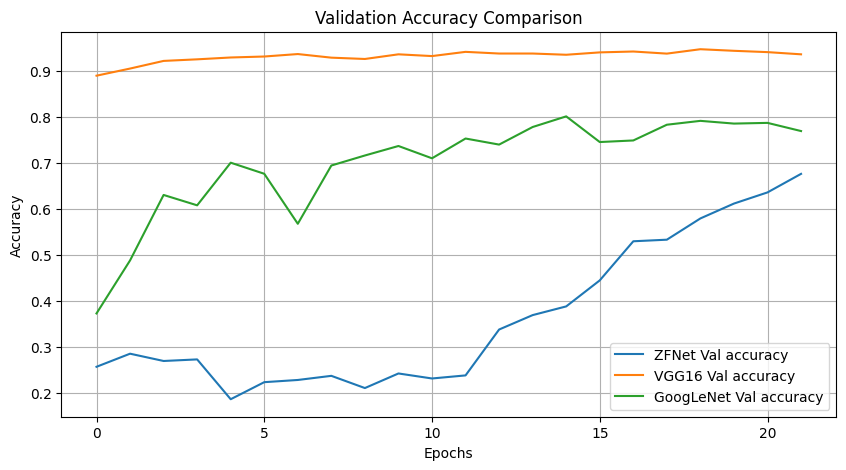

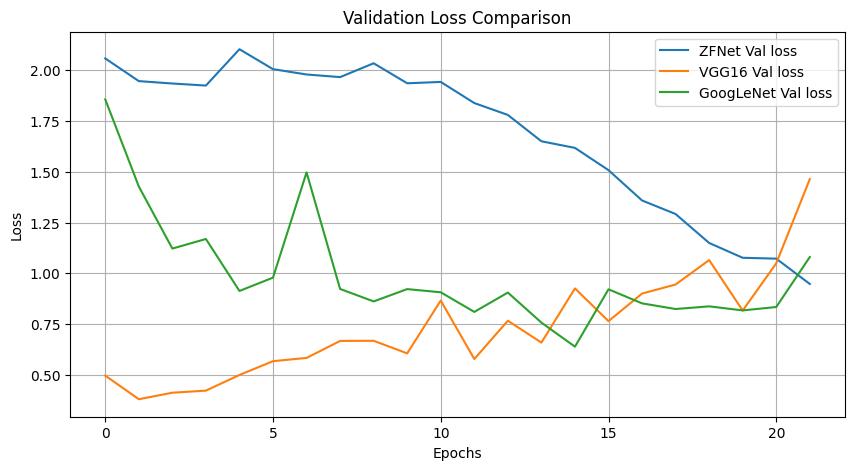


Model Performance Summary:
ZFNet: Accuracy=0.6766, Loss=0.9479, Inference Time=2706.71s
VGG16: Accuracy=0.9365, Loss=1.4638, Inference Time=3760.86s
GoogLeNet: Accuracy=0.7697, Loss=1.0803, Inference Time=2049.47s


In [ ]:
models_to_train = {
    "ZFNet": build_zfnet_improved(),
    "VGG16": build_vgg16(),  # keep this as is
    "GoogLeNet": build_googlenet_improved()
}


history_dict = {}
results = {}

for name, model in models_to_train.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    history = model.fit(train_generator, validation_data=val_generator, epochs=22,class_weight=class_weight_dict)
    end_time = time.time()

    loss, accuracy = model.evaluate(val_generator)
    inference_time = (end_time - start_time)

    history_dict[name] = history
    results[name] = {
        "accuracy": accuracy,
        "loss": loss,
        "inference_time": inference_time
    }

# Step 5: Plot accuracy/loss
for metric in ['accuracy', 'loss']:
    plt.figure(figsize=(10, 5))
    for name, history in history_dict.items():
        plt.plot(history.history['val_' + metric], label=f'{name} Val {metric}')
    plt.title(f'Validation {metric.title()} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 6: Print comparison results
print("\nModel Performance Summary:")
for name, result in results.items():
    print(f"{name}: Accuracy={result['accuracy']:.4f}, Loss={result['loss']:.4f}, Inference Time={result['inference_time']:.2f}s")



{0: 'cane', 1: 'cavallo', 2: 'elefante', 3: 'farfalla', 4: 'gallina', 5: 'gatto', 6: 'mucca', 7: 'pecora', 8: 'ragno', 9: 'scoiattolo'}


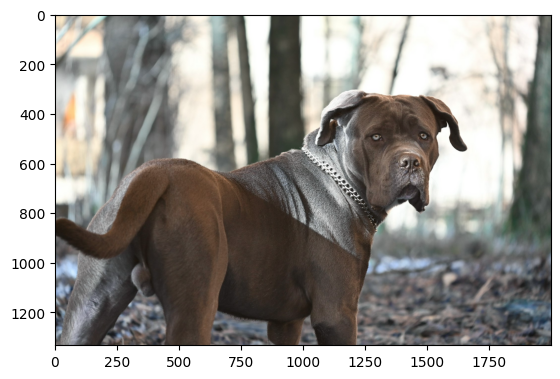

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
ZFNet predicts: gatto
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
VGG16 predicts: cane
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
GoogLeNet predicts: cane


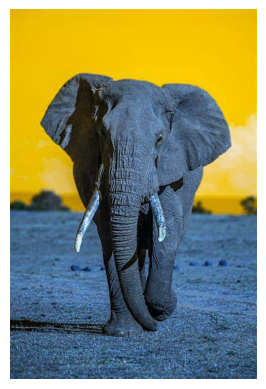

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
ZFNet predicts: elefante
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
VGG16 predicts: elefante
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
GoogLeNet predicts: elefante


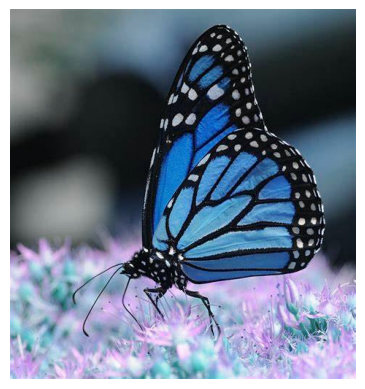

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
ZFNet predicts: farfalla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
VGG16 predicts: farfalla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
GoogLeNet predicts: farfalla


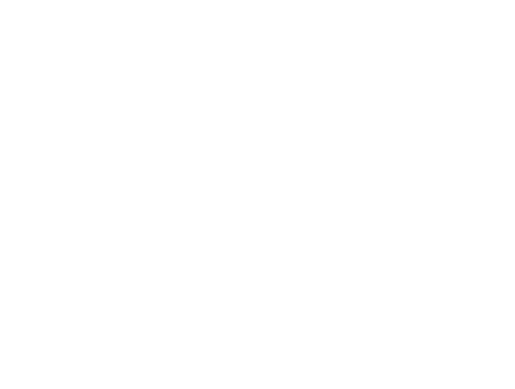

In [ ]:
# Predicting and testing

def load_and_prepare_image_cv2(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224,224))             # Resize to (224, 224)
    img = preprocess_input(img)                 # Same VGG16 preprocessing
    img = np.expand_dims(img, axis=0)
    plt.axis("off")           # Add batch dimension
    return img

class_labels = {v: k for k, v in train_generator.class_indices.items()}
print(class_labels)
# Predict using each model

def trained_model_predict(models,test_path):
  for i in test_path:
    image1= cv2.imread(i)
    plt.imshow(image1)
    plt.show()
    img_input = load_and_prepare_image_cv2(i)
    for name, model in models.items():
      prediction = model.predict(img_input)
      predicted_class = np.argmax(prediction)
      label = class_labels[predicted_class]
      print(f"{name} predicts: {label}")

paths=['cane.jpg','elephant.jpg','farfalla.jpg']
trained_model_predict(models_to_train,paths)
